## Naimportovaný marek.coderslab@gmail.com.ics z Google Calendar

In [1]:
# import pandas as pd
# from icalendar import Calendar

# # Načti ICS soubor
# with open("marek.coderslab@gmail.com.ics", "rb") as f:
#     gcal = Calendar.from_ical(f.read())

# events = []
# for component in gcal.walk():
#     if component.name == "VEVENT":
#         events.append({
#             "summary": str(component.get("summary")),
#             "start": component.get("dtstart").dt,
#             "end": component.get("dtend").dt,
#             "description": str(component.get("description")),
#         })

# df = pd.DataFrame(events)
# print(df.head())


In [2]:
# !pip install icalendar


# Kód při stažení .zip s .ics z Export calendar "Marek.Coderslab"

In [3]:
# import pandas as pd
# from icalendar import Calendar
# import zipfile
# import re

# zip_path = "marek.coderslab@gmail.com.ical.zip"

# # otevřeme ZIP a najdeme ICS soubor
# with zipfile.ZipFile(zip_path, "r") as z:
#     # najdi soubor končící na .ics (pokud jich je víc, vezme první)
#     ics_name = [f for f in z.namelist() if f.endswith(".ics")][0]
#     with z.open(ics_name) as f:
#         gcal = Calendar.from_ical(f.read())

# events = []
# for component in gcal.walk():
#     if component.name == "VEVENT":
#         summary = str(component.get("summary") or "")

#         # odstraň prefix "TOPFIT:" bez ohledu na velikost
#         clean_summary = re.sub(r"^\s*TOPFIT:\s*", "", summary, flags=re.IGNORECASE).strip()

#         start = component.get("dtstart").dt
#         end = component.get("dtend").dt

#         events.append({
#             "summary": clean_summary,
#             "start": start,
#             "end": end
#         })

# df_topfit = pd.DataFrame(events)

# # jen datum
# df_topfit["date"] = pd.to_datetime(df_topfit["start"]).dt.date

# # délka v minutách
# df_topfit["doba"] = (df_topfit["end"] - df_topfit["start"]).dt.total_seconds() / 60

# # vyber sloupce a seřaď od nejnovějšího
# df_topfit = df_topfit[["date", "summary", "doba"]].sort_values("date", ascending=False).reset_index(drop=True)

# print(df_topfit.head(20))


In [4]:
# !pip install google-api-python-client google-auth-httplib2 google-auth-oauthlib pandas


# Kód využívající přímé připojení na Google calendar API

In [1]:
import os
import pandas as pd
import re
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from datetime import datetime

# aplikace může pouze číst události z kalendáře (žádné přidávání, mazání ani úpravy).
SCOPES = ["https://www.googleapis.com/auth/calendar.readonly"]

# Funkce pro získání service objektu API
def get_service():
    creds = None
    if os.path.exists("token.json"):
        creds = Credentials.from_authorized_user_file("token.json", SCOPES) # když někdy dřív přihlásil, vygeneroval se soubor token.json
    if not creds or not creds.valid: # pokud token vypršel, ale máš refresh_token → obnoví se automaticky na pozadí
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else: # pokud žádný token není → otevře se prohlížeč, kde se přihlásíš ke Google účtu
            flow = InstalledAppFlow.from_client_secrets_file("client_secret_1058953791301-pucaisjv7jacmllg5igtsftqlui6qmgd.apps.googleusercontent.com.json", SCOPES)
            creds = flow.run_local_server(port=0)
        with open("token.json", "w") as token: # uloží se nový token do souboru token.json, aby příště fungovalo přihlášení automaticky
            token.write(creds.to_json())
    service = build("calendar", "v3", credentials=creds) # vytvoří objekt service, který umí volat Google Calendar API (verze 3)
    return service

# Funkce pro načtení událostí
def fetch_events(calendar_id, max_results=250): # calendar_id = ID kalendáře, ze kterého chceš číst (např. "primary" pro hlavní kalendář Google účtu), max_results = maximální počet událostí, které se mají načíst (defaultně 250)
    service = get_service() # přihlášení a vrátí objekt service, který umí komunikovat s API Google Calendar
    events_result = service.events().list( # hlavní dotaz na API
        calendarId=calendar_id,
        timeMin="2025-01-01T00:00:00Z",  # začátek období
        maxResults=max_results,
        singleEvents=True,
        orderBy="startTime"
    ).execute() # pošle požadavek na server a vrátí odpověď (JSON)
    events = events_result.get("items", []) # odpověď z API (events_result) je slovník, klíč "items" obsahuje skutečné události
    return events # funkce vrací list událostí (každá událost je slovník s informacemi: id, summary, start, end, …)

def events_to_df(events): # events_to_df převádí seznam událostí z Google Kalendáře (který dostaneš třeba z fetch_events) do pandas DataFrame
    rows = []
    for e in events: # Prochází se každá událost e
        summary = e.get("summary", "") # vezme text z summary
        clean_summary = re.sub(r"^\s*TOPFIT:\s*", "", summary, flags=re.IGNORECASE).strip() # pomocí regexu odstraní případný prefix "TOPFIT:" na začátku názvu (bez ohledu na velikost písmen)
        
        # událost může mít buď celodenní datum (date), nebo časový údaj (dateTime)
        start_str = e["start"].get("dateTime", e["start"].get("date"))
        end_str = e["end"].get("dateTime", e["end"].get("date"))

        # převede stringy na datetime objekty (pandas)
        start_dt = pd.to_datetime(start_str)
        end_dt = pd.to_datetime(end_str)

        # rozdíl konce a začátku → délka události v minutách
        duration_min = (end_dt - start_dt).total_seconds() / 60

        # vezme volitelný popis z události (pokud existuje)
        description = e.get("description", "").strip()

        # číslo "energy" hledá první číslo (kalorie), pokud najde převede na číslo, jinak None
        match = re.search(r"\d+", description)
        energy = int(match.group(0)) if match else None

        # "note" = text za pomlčkou 
        note = None
        if "-" in description:
            note = description.split("-", 1)[1].strip()  # vezme část za první pomlčkou

        # uloží se do seznamu: date, summary, doba, energy, note
        rows.append({
            "date": start_dt.date(),
            "summary": clean_summary,
            "doba": duration_min,
            "energy": energy,
            "note": note   # nový sloupec
        })
    # všechny nasbírané řádky se převedou do tabulky (DataFrame)
    df = pd.DataFrame(rows)

    # z datumu se vypočítá měsíc (month) a číslo týdne (week) podle ISO kalendáře
    df["month"] = pd.to_datetime(df["date"]).dt.month
    df["week"] = pd.to_datetime(df["date"]).dt.isocalendar().week

    # seřadí události od nejnovějších po nejstarší, resetuje index (od 0,1,2,…)
    df = df.sort_values("date", ascending=False).reset_index(drop=True)
    return df # vrací pandas DataFrame připravený na analýzu




# Tenhle kód stáhne tvé události z Google Kalendáře marek.coderslab@gmail.com a převede je do tabulky df, se kterou už můžeš dělat analýzy a grafy v Pythonu
calendar_id = "marek.coderslab@gmail.com"
events = fetch_events(calendar_id)
df = events_to_df(events)

print(df)
# Uložení DataFrame do CSV
# df.to_csv("topfit_cviceni.csv", index=False, encoding="utf-8-sig")


/Users/Marek/miniconda3/envs/snmp_fresh/lib/python3.10/site-packages/google/api_core/_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.18) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)


          date                  summary   doba  energy            note  month  \
0   2026-01-15             nohy, břicho   65.0     328            None      1   
1   2026-01-12           Doma: Nohy, PB   55.0     297            None      1   
2   2026-01-08              ZRT, břicho   71.0     411            None      1   
3   2026-01-06  Doma: Nohy, ZRT, bricho   63.0     255            None      1   
4   2026-01-05  Doma: Nohy, ZRT, bricho   62.0     262            None      1   
5   2025-12-18   Doma: Nohy, PB, bricho   65.0     278            None     12   
6   2025-12-15  Doma: Nohy, ZRT, bricho   72.0     313            None     12   
7   2025-12-10   Doma: Nohy, PB, bricho   60.0     350            None     12   
8   2025-12-04    Doma: PB, ZRT, bricho   70.0     218            None     12   
9   2025-12-01    Doma: PB, ZRT, bricho   70.0     206            None     12   
10  2025-11-27        Doma: ZRT, bricho   72.0     199            None     11   
11  2025-11-24              

In [2]:
# events = fetch_events("primary", max_results=50)

# for e in events:
#     print(e["summary"], e["start"], e["end"])


In [3]:
# for e in events:
#     description = e.get("description", "")
#     print(">>> description:", description)   # DEBUG, ať vidíš obsah

# cmd - shift - /

## Sjednocení názvů workout

In [4]:
import pandas as pd
import unicodedata

# --- 1) Funkce pro normalizaci textu na kategorie ---
def normalize_summary(text: str) -> list[str]:
    text = text.strip().upper()
    text_ascii = ''.join(
        c for c in unicodedata.normalize('NFD', text)
        if unicodedata.category(c) != 'Mn'
    )

    categories = []
    if "ZRT" in text_ascii:
        categories.append("ZRT")
    if "PB" in text_ascii:
        categories.append("PB")
    if "NOHY" in text_ascii:
        categories.append("NOHY")
    if "BRICHO" in text_ascii:
        categories.append("BRICHO")

    if not categories:  # fallback, kdyby se nenašlo nic
        categories.append(text_ascii)

    return categories



# Normalizace
df["summary_norm"] = df["summary"].apply(normalize_summary)

# Vytvořit seznam slovníků pro explode
def make_explode_list(row):
    n = len(row["summary_norm"])
    return [{"summary_norm": cat, 
             "doba_per_category": row["doba"]/n, 
             "energy_per_category": row["energy"]/n} 
            for cat in row["summary_norm"]]

df["explode_list"] = df.apply(make_explode_list, axis=1)

# Explode
df_exploded = df.explode("explode_list").reset_index(drop=True)

# Rozbalení slovníků do sloupců
df_exploded = pd.concat([df_exploded.drop(columns=["explode_list","summary_norm","doba","energy"]),
                         df_exploded["explode_list"].apply(pd.Series)], axis=1)


# --- 7) Pivot tabulka pro přehled po dnech a kategoriích ---
df_pivot = (
    df_exploded
    .groupby(["date", "summary_norm"])
    [["doba_per_category", "energy_per_category"]]
    .sum()
    .unstack(fill_value=0)
)

print("Exploded DataFrame:")
print(df_exploded)
print("\nPivot tabulka:")
print(df_pivot)

df_exploded.to_csv("topfit_rozdel_cviceni.csv", index=False, encoding="utf-8-sig")

Exploded DataFrame:
          date         summary  note  month  week summary_norm  \
0   2026-01-15    nohy, břicho  None      1     3         NOHY   
1   2026-01-15    nohy, břicho  None      1     3       BRICHO   
2   2026-01-12  Doma: Nohy, PB  None      1     3           PB   
3   2026-01-12  Doma: Nohy, PB  None      1     3         NOHY   
4   2026-01-08     ZRT, břicho  None      1     2          ZRT   
..         ...             ...   ...    ...   ...          ...   
89  2025-07-10              PB  None      7    28           PB   
90  2025-07-07             ZRT  None      7    28          ZRT   
91  2025-07-03              PB  None      7    27           PB   
92  2025-06-30             ZRT  None      6    27          ZRT   
93  2025-06-26              PB  None      6    26           PB   

    doba_per_category  energy_per_category  
0                32.5                164.0  
1                32.5                164.0  
2                27.5                148.5  
3      

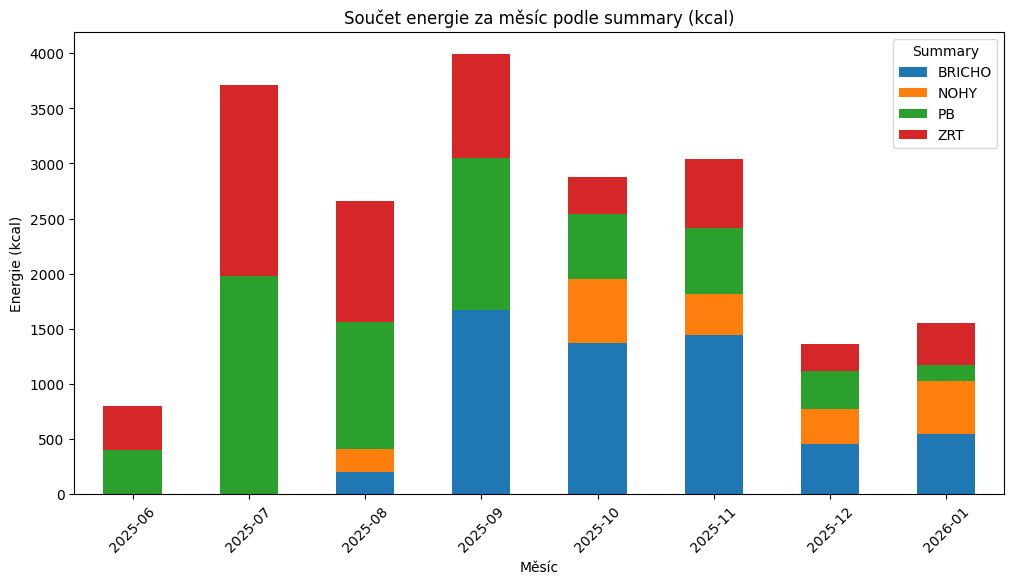

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

# Měsíc jako perioda
df_exploded["month"] = pd.to_datetime(df_exploded["date"]).dt.to_period("M")

# Součet energie za kombinaci měsíc × summary
energy_sum = df_exploded.groupby(["month", "summary_norm"])["energy_per_category"].sum().unstack(fill_value=0)

# Graf – stacked bar chart
energy_sum.plot(kind="bar", stacked=True, figsize=(12,6))
plt.title("Součet energie za měsíc podle summary (kcal)")
plt.xlabel("Měsíc")
plt.ylabel("Energie (kcal)")
plt.xticks(rotation=45)
plt.legend(title="Summary")
plt.show()



In [6]:
df_exploded.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype    
---  ------               --------------  -----    
 0   date                 94 non-null     object   
 1   summary              94 non-null     object   
 2   note                 16 non-null     object   
 3   month                94 non-null     period[M]
 4   week                 94 non-null     UInt32   
 5   summary_norm         94 non-null     object   
 6   doba_per_category    94 non-null     float64  
 7   energy_per_category  94 non-null     float64  
dtypes: UInt32(1), float64(2), object(4), period[M](1)
memory usage: 5.7+ KB


In [7]:
import pandas as pd

# Převod datumu na měsíc
df_exploded["month"] = pd.to_datetime(df_exploded["date"]).dt.to_period("M")

# Pivotní tabulka: součet energie podle měsíce a summary_norm
energy_pivot = pd.pivot_table(
    df_exploded,
    index="date",
    columns="summary_norm",
    values="energy_per_category",
    aggfunc="sum",
    # fill_value=0
)

# Nahrazení NaN prázdným řetězcem

energy_pivot_clean = energy_pivot.replace({pd.NA: "", None: "", float("nan"): ""})
# energy_pivot_rounded = energy_pivot.round(0).astype("Int64")

energy_pivot_rounded = energy_pivot.round(0)

# Převedeme na string, zaokrouhlíme, a nahradíme NaN prázdným řetězcem
energy_pivot_clean = energy_pivot_rounded.map(
    lambda x: "" if pd.isna(x) else str(int(x))
)

# Zobrazení tabulky
energy_pivot_clean.sort_values("date", ascending=False).head(10)




summary_norm,BRICHO,NOHY,PB,ZRT
date,,,,
2026-01-15,164,164,,
2026-01-12,,148,148,
2026-01-08,206,,,206
2026-01-06,85,85,,85
2026-01-05,87,87,,87
2025-12-18,93,93,93,
2025-12-15,104,104,,104
2025-12-10,117,117,117,
2025-12-04,73,,73,73


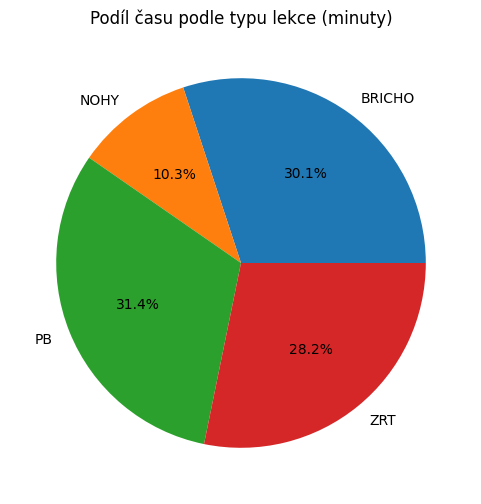

In [8]:
import matplotlib.pyplot as plt

# součet času (doba) podle typu lekce
time_per_lesson = df_exploded.groupby("summary_norm")["doba_per_category"].sum()

# koláčový graf
time_per_lesson.plot(
    kind="pie",
    autopct="%1.1f%%",
    figsize=(6,6)
)
plt.title("Podíl času podle typu lekce (minuty)")
plt.ylabel("")  # odstraní popisek y-osi
plt.show()



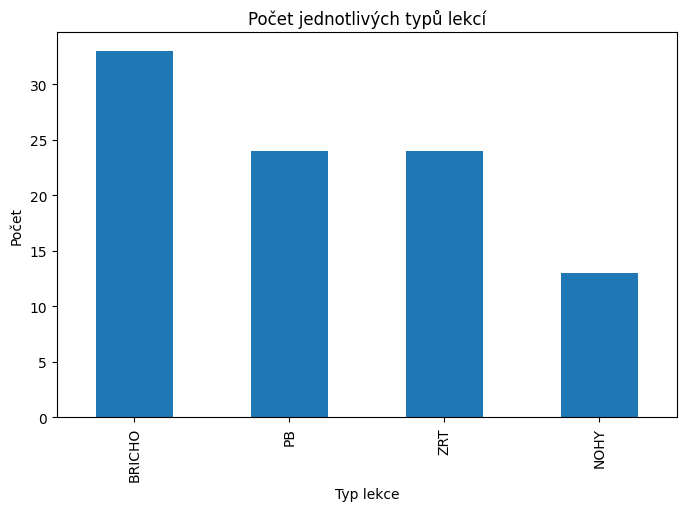

In [9]:
df_exploded["summary_norm"].value_counts().plot(kind="bar", figsize=(8,5))
plt.title("Počet jednotlivých typů lekcí")
plt.xlabel("Typ lekce")
plt.ylabel("Počet")
plt.show()


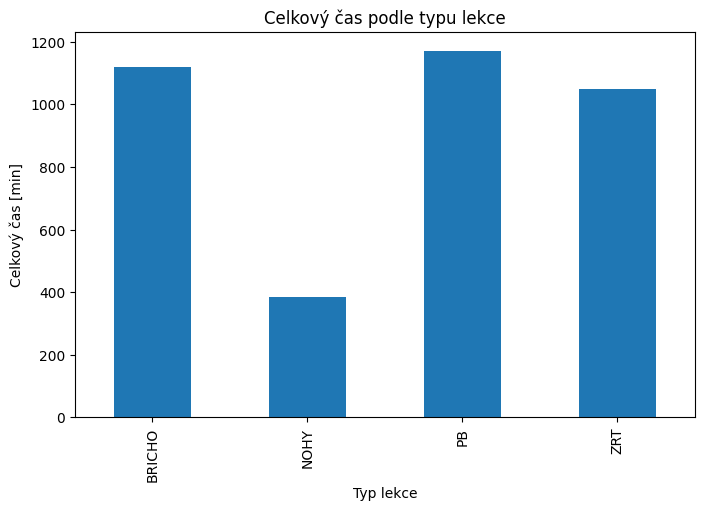

In [10]:
df_exploded.groupby("summary_norm")["doba_per_category"].sum().plot(kind="bar", figsize=(8,5))
plt.title("Celkový čas podle typu lekce")
plt.ylabel("Celkový čas [min]")
plt.xlabel("Typ lekce")
plt.show()


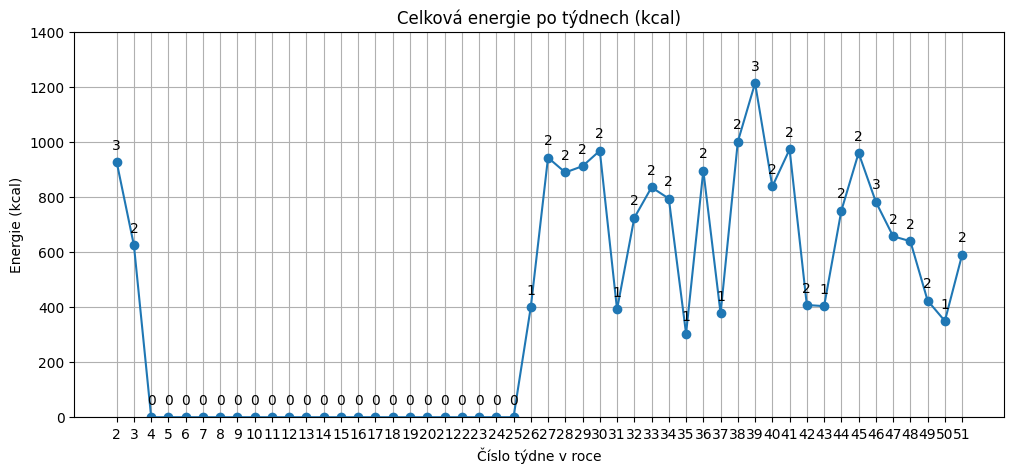

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# jistota: ISO týden jako int
df_exploded["week"] = pd.to_datetime(df["date"]).dt.isocalendar().week.astype(int)

# kompletní rozsah týdnů (v rámci dat v df)
all_weeks = pd.RangeIndex(df["week"].min(), df["week"].max() + 1)

# součet energie po týdnech (0 pro chybějící týdny)
weekly_energy = (
    df.groupby("week", observed=True)["energy"]
      .sum(min_count=1)              # když v týdnu není žádná energie, zůstane NaN
      .reindex(all_weeks, fill_value=0)
      .fillna(0)
)

# počet lekcí po týdnech (pro popisky)
weekly_counts = (
    df.groupby("week", observed=True)
      .size()
      .reindex(all_weeks, fill_value=0)
)

# graf
ax = weekly_energy.plot(kind="line", marker="o", figsize=(12, 5))
ax.set_ylim(0, 1400)
plt.title("Celková energie po týdnech (kcal)")
plt.xlabel("Číslo týdne v roce")
plt.ylabel("Energie (kcal)")
plt.xticks(list(all_weeks))
plt.grid(True)

# popisky: počet lekcí nad body
offset = max(1, weekly_energy.max() * 0.03)  # drobný odsaz
for week, value in weekly_energy.items():
    ax.text(week, value + offset, str(int(weekly_counts.loc[week])), ha="center", va="bottom")

plt.show()



/var/folders/px/7v29qw4j1fq7r7dx3wzzggyr0000gn/T/ipykernel_1742/1700648212.py:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("coolwarm")   # nebo "viridis", "plasma" atd.


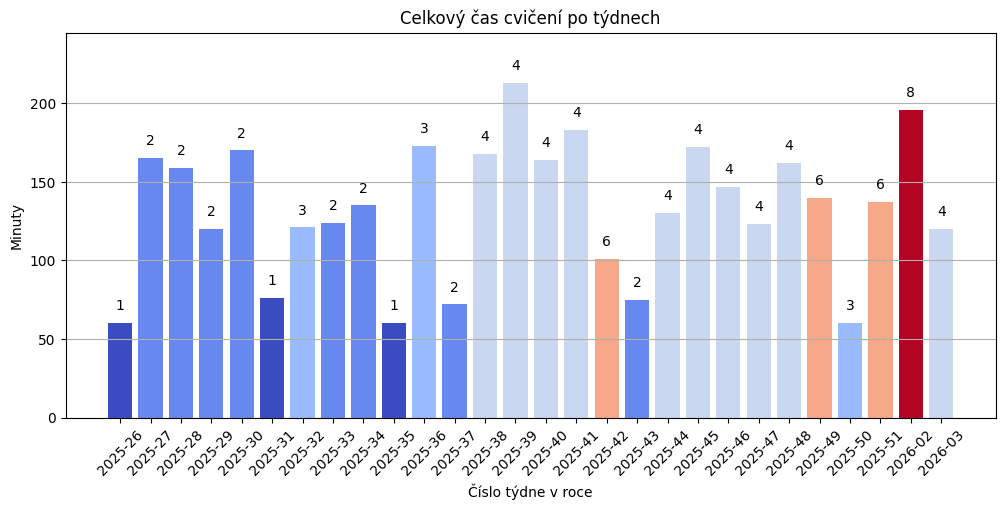

In [14]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd

# --- jistota: vytvoř sloupec week jako int ---
# df_exploded["week"] = pd.to_datetime(df["date"]).dt.isocalendar().week.astype(int)
# iso = pd.to_datetime(df["date"]).dt.isocalendar() # stará verze
# df_exploded["week"] = iso.year.astype(str) + "-" + iso.week.astype(str).str.zfill(2) # stará verze
iso = pd.to_datetime(df_exploded["date"]).dt.isocalendar()
df_exploded["week"] = (
    iso.year.astype(str) + "-" + iso.week.astype(str).str.zfill(2)
)


# kompletní rozsah týdnů (int list)
# start_week = int(df["week"].min())
# end_week = int(df["week"].max())
# all_weeks = list(range(start_week, end_week + 1))
# all_weeks = sorted(df_exploded["week"].unique())
df_exploded["week"] = df_exploded["week"].astype(str) 
all_weeks = sorted(df_exploded["week"].unique())

# součet minut (doba) po týdnech, přeuspořádaný podle all_weeks
weekly_minutes = (
    df_exploded.groupby("week", observed=True)["doba_per_category"]
      .sum()
      .reindex(all_weeks, fill_value=0)
      .astype(float)
)

# počet lekcí po týdnech (pro barvy / popisky)
weekly_counts = (
    df_exploded.groupby("week", observed=True)
      .size()
      .reindex(all_weeks, fill_value=0)
      .astype(int)
)

# --- barevná škála podle počtu lekcí ---
vmin = weekly_counts.min()
vmax = weekly_counts.max()
# zabrání dělení nulou, když jsou všechny hodnoty stejné
if vmin == vmax:
    norm = plt.Normalize(vmin - 1, vmax + 1)
else:
    norm = plt.Normalize(vmin, vmax)
cmap = cm.get_cmap("coolwarm")   # nebo "viridis", "plasma" atd.
colors = cmap(norm(weekly_counts.values))

# --- vykreslení ---
fig, ax = plt.subplots(figsize=(12, 5))
x = np.arange(len(all_weeks))  # pozice na ose x - nechat

bars = ax.bar(x, weekly_minutes.values, color=colors)
ax.set_ylim(0, max(130, weekly_minutes.max() * 1.15))  # minimální max 130, nebo dynamické
ax.set_title("Celkový čas cvičení po týdnech")
ax.set_xlabel("Číslo týdne v roce")
ax.set_ylabel("Minuty")
ax.set_xticks(x) # nechat
ax.set_xticklabels(all_weeks, rotation=45) # nechat
ax.grid(axis="y")

# přidání počtu lekcí nad sloupce
offset = max(1, weekly_minutes.max() * 0.03)
for i, (val, cnt) in enumerate(zip(weekly_minutes.values, weekly_counts.values)):
    ax.text(i, val + offset, str(int(cnt)), ha='center', va='bottom')

plt.show()



Sekvenční (pro hodnoty od nízké po vysokou)

    viridis – tmavě modrá → žlutá, velmi dobře čitelná

    plasma – fialová → žlutá, kontrastní a živá

    inferno – černá → žlutá, hodně kontrastu

    magma – tmavá → světle fialová, jemnější než inferno

    cividis – modro-žlutá, vhodné pro barevně slabozraké

2️⃣ Divergentní (pro hodnoty kolem střední hodnoty)

    coolwarm – modrá ↔ červená

    bwr – modrá ↔ bílá ↔ červená

    seismic – tmavě modrá ↔ bílá ↔ červená

3️⃣ Kategorické / diskrétní

    tab10, tab20, Set1, Set2, Accent – pro oddělení skupin/barvy jednotlivých kategorií